# Projeto 3 - Ciência dos Dados

#### Stephanie Wertheimer, Thomas Pilnik e Victor Sznifer

Temos duas bases de dados: uma que fala sobre medições da quantidade de E. Coli nas praias de Chicago, e outra que mede diferentes características físicas da água. Nosso objetivo é buscar uma relação entre a proliferação de bactérias e os parâmetros utlizados para analisar a água. Faremos isso usando um modelo de regressão linear. Em seguida, faremos uma regressão logística que medirá a probabilidade de uma praia ser ou não própria para banho (fator regulado, por entre outros fatores, pela quantidade de E. Coli na água) de acordo com suas características físicas. 

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import math

In [2]:
print('Esperamos trabalhar no diretório')
print(os.getcwd())

Esperamos trabalhar no diretório
C:\Users\victo


In [3]:
lab = pd.read_csv('Beach_Lab_Data.csv', sep=',')

In [4]:
lab.columns = ["DNATestID", "Timestamp", "Beach", "DNA1","DNA2", "DNAMean", "CultureTestID","Sample1TimeStamp","Sample1Reading","Sample2Reading","ReadingMean","CultureNote","SampleInterval","Sample2TimeStamp","Latitude","Longitude","Location"]

In [5]:
lab = pd.DataFrame(lab.loc[:, ["DNATestID", "Beach", "DNAMean","ReadingMean","Sample1TimeStamp"]])

lab=lab.drop(lab[lab.Beach == 'Margaret T Burroughs'].index)
lab=lab.drop(lab[lab.Beach == 'Margaret T Burroughs'].index)
lab=lab.drop(lab[lab.Beach == 'South Shore'].index)
lab=lab.drop(lab[lab.Beach == '12th Street'].index)
lab=lab.drop(lab[lab.Beach == 'North Avenue'].index)
lab=lab.drop(lab[lab.Beach == 'Humboldt'].index)

lab['Sample1TimeStamp']=pd.to_datetime(lab.Sample1TimeStamp).dt.date

lab.head()


,DNATestID,Beach,DNAMean,ReadingMean,Sample1TimeStamp
0,NaN,NaN,NaN,239.3,2013-08-15
2,NaN,Hartigan,NaN,69.0,2010-06-02
5,NaN,Marion Mahony Griffin,NaN,7.1,2015-08-13
7,NaN,Marion Mahony Griffin,NaN,57.8,2007-08-17
8,NaN,Hartigan,NaN,10.8,2015-09-04


In [6]:
water = pd.read_csv('Beach_Water_Quality_-_Automated_Sensors.csv', sep=',')

water.columns = ["Beach", "Timestamp", "WtrTemperature", "Turbidity","TransducerDepth", "WaveHeight", "WavePeriod", "BatteryLife","TimestampLabel","ID"]


In [7]:
water=pd.DataFrame(water.loc[:, ["Beach", "WtrTemperature", "Turbidity","TransducerDepth", "WaveHeight", "WavePeriod", "TimestampLabel"]])
water=water.drop(water[water.Beach == 'Osterman Beach'].index)

water['Nível']='Médio'
water.loc[(water.Beach == "Montrose Beach"), "Nível"] = "Montrose"
water.loc[(water.Beach == "Calumet Beach"), "Nível"] = "Calumet"
water.loc[(water.Beach == "Ohio Street Beach"), "Nível"] = "Ohio Street"
water.loc[(water.Beach == "Rainbow Beach"), "Nível"] = "Rainbow"
water.loc[(water.Beach == "63rd Street Beach"), "Nível"] = "63rd Street"

del water['Beach']

water['TimestampLabel']=pd.to_datetime(water.TimestampLabel).dt.date

water.head()


,WtrTemperature,Turbidity,TransducerDepth,WaveHeight,WavePeriod,TimestampLabel,Nível
0,20.3,1.18,0.891,0.080,3.0,2013-08-30,Montrose
1,14.4,1.23,NaN,0.111,4.0,2016-05-26,Ohio Street
2,23.2,3.63,1.201,0.174,6.0,2013-09-03,Calumet
3,16.2,1.26,1.514,0.147,4.0,2014-05-28,Calumet
4,14.4,3.36,1.388,0.298,4.0,2014-05-28,Montrose


In [8]:
joined = lab.set_index('Beach').join(water.set_index('Nível'), how='inner', lsuffix='lab', rsuffix='_water')
joined.head()


,DNATestID,DNAMean,ReadingMean,Sample1TimeStamp,WtrTemperature,Turbidity,TransducerDepth,WaveHeight,WavePeriod,TimestampLabel
63rd Street,1989.0,29.3,NaN,NaN,16.3,1.66,1.633,0.209,3.0,2014-06-13
63rd Street,1989.0,29.3,NaN,NaN,18.9,7.56,1.517,0.140,4.0,2013-09-18
63rd Street,1989.0,29.3,NaN,NaN,17.7,1.07,1.700,0.153,2.0,2014-06-13
63rd Street,1989.0,29.3,NaN,NaN,25.4,3.45,-0.072,0.031,9.0,2014-06-12
63rd Street,1989.0,29.3,NaN,NaN,16.5,1.68,1.627,0.168,3.0,2014-06-12


In [9]:
new_df = pd.merge(lab, water,  how='inner', left_on=['Beach','Sample1TimeStamp'], right_on = ['Nível','TimestampLabel'])

new_df.head()

,DNATestID,Beach,DNAMean,ReadingMean,Sample1TimeStamp,WtrTemperature,Turbidity,TransducerDepth,WaveHeight,WavePeriod,TimestampLabel,Nível
0,983.0,Rainbow,20.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Rainbow
1,1070.0,Rainbow,26.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Rainbow
2,1631.0,Rainbow,136.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Rainbow
3,1567.0,Rainbow,230.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Rainbow
4,1408.0,Rainbow,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Rainbow


In [11]:
#Seleciona o ano de 2010 e remove os NaNs
Temperatura = new_df[['ReadingMean','WtrTemperature']].dropna()

Temperatura

,ReadingMean,WtrTemperature
629,844.0,22.7
630,844.0,22.7
631,844.0,22.7
632,844.0,22.6
633,844.0,22.6
634,844.0,22.6
635,844.0,22.5
636,844.0,22.5
637,844.0,25.1
638,844.0,22.5


In [12]:
print("Covariância entre ReadingMean e WaterTemperature:",Temperatura.ReadingMean.cov(Temperatura.WtrTemperature))

print("Correlação entre ReadingMean e WaterTemperature:",Temperatura.ReadingMean.corr(Temperatura.WtrTemperature))


Covariância entre ReadingMean e WaterTemperature: -73.8015378912
Correlação entre ReadingMean e WaterTemperature: -0.047056310804


In [13]:
# Regressão entre ReadingMean e WaterTemperature com ajuste linear

a = Temperatura.ReadingMean.cov(Temperatura.WtrTemperature) / Temperatura.ReadingMean.var()
b = Temperatura.WtrTemperature.mean() - a*Temperatura.ReadingMean.mean()

print('Ajuste linear entre X3 e X4:')
print('Coeficiente linear:', b)
print('Coeficiente angular:', a)

Ajuste linear entre X3 e X4:
Coeficiente linear: 19.4112129038
Coeficiente angular: -0.0003604107792


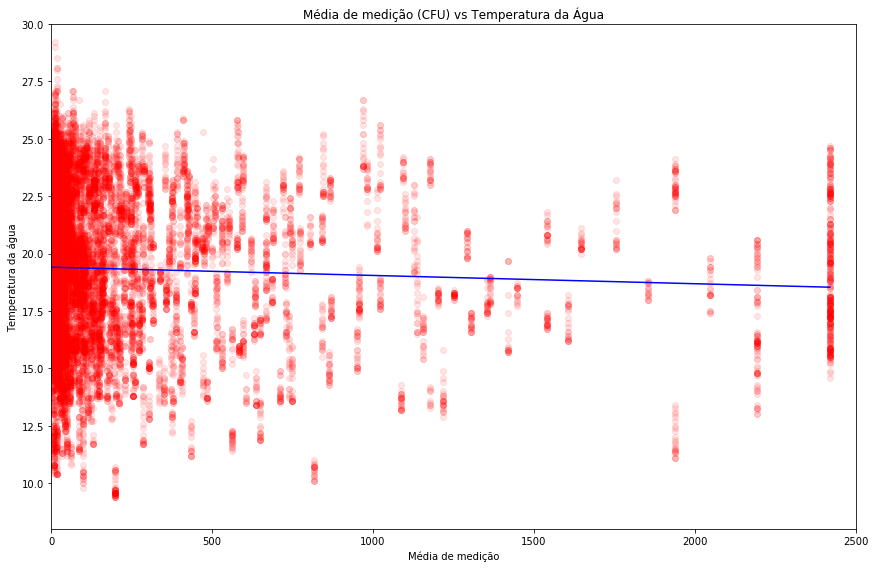

In [14]:
fig = plt.figure(figsize=(12, 8))
plt.scatter(Temperatura.ReadingMean, Temperatura.WtrTemperature, c='red', alpha=0.1)
plt.title('Média de medição (CFU) vs Temperatura da Água')
plt.xlabel('Média de medição')
plt.ylabel('Temperatura da água')

plt.plot((Temperatura.ReadingMean.min(),Temperatura.ReadingMean.max()), (a*Temperatura.ReadingMean.min()+b, a*Temperatura.ReadingMean.max()+b), color='blue')

plt.tight_layout()
plt.axis([0,2500,8,30])
plt.show()

In [16]:
Turbidez = new_df[['ReadingMean',"Turbidity"]].dropna()
Transdutor = new_df[['ReadingMean',"TransducerDepth"]].dropna()
Altura_Onda = new_df[['ReadingMean',"WaveHeight"]].dropna()
Periodo_Onda = new_df[['ReadingMean',"WavePeriod"]].dropna()

In [22]:
# Regressão entre ReadingMean e Turbidez com ajuste linear

a = Turbidez.ReadingMean.cov(Turbidez.Turbidity) / Turbidez.ReadingMean.var()
b = Turbidez.Turbidity.mean() - a*Turbidez.ReadingMean.mean()

print('Ajuste linear entre X3 e X4:')
print('Coeficiente linear:', b)
print('Coeficiente angular:', a)

Ajuste linear entre X3 e X4:
Coeficiente linear: 4.82831140016
Coeficiente angular: -0.00137499407935


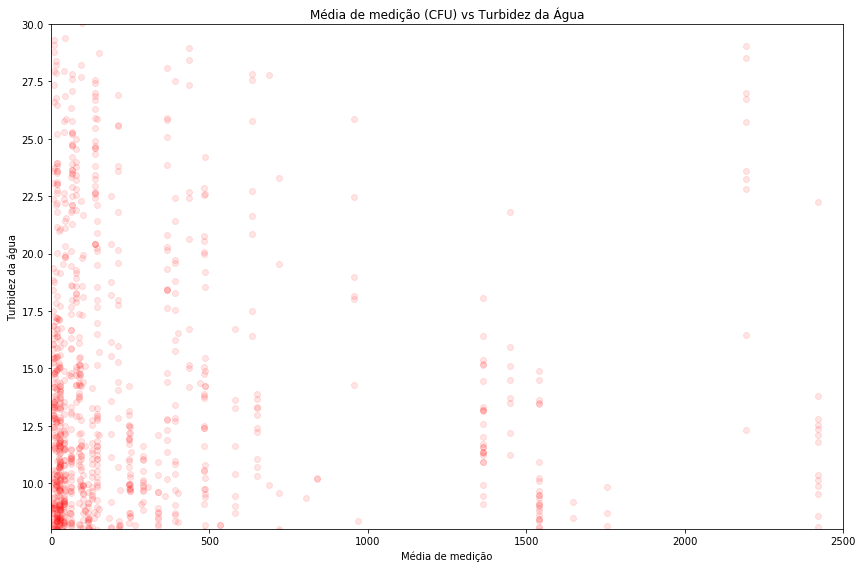

In [23]:
fig = plt.figure(figsize=(12, 8))
plt.scatter(Turbidez.ReadingMean, Turbidez.Turbidity, c='red', alpha=0.1)
plt.title('Média de medição (CFU) vs Turbidez da Água')
plt.xlabel('Média de medição')
plt.ylabel('Turbidez da água')

plt.plot((Turbidez.ReadingMean.min(),Turbidez.ReadingMean.max()), (a*Turbidez.ReadingMean.min()+b, a*Turbidez.ReadingMean.max()+b), color='blue')

plt.tight_layout()
plt.axis([0,2500,8,30])
plt.show()

In [24]:
# Regressão entre ReadingMean e profundidade do Transdutor com ajuste linear

a = Transdutor.ReadingMean.cov(Transdutor.TransducerDepth) / Transdutor.ReadingMean.var()
b = Transdutor.TransducerDepth.mean() - a*Transdutor.ReadingMean.mean()

print('Ajuste linear entre X3 e X4:')
print('Coeficiente linear:', b)
print('Coeficiente angular:', a)

Ajuste linear entre X3 e X4:
Coeficiente linear: 1.61553339031
Coeficiente angular: 5.07232930544e-07


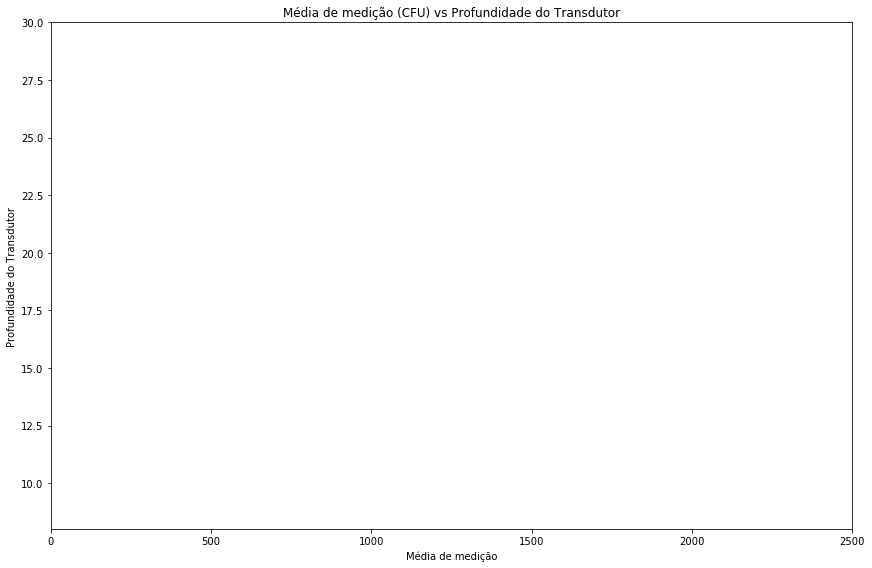

In [25]:
fig = plt.figure(figsize=(12, 8))
plt.scatter(Transdutor.ReadingMean, Transdutor.TransducerDepth, c='red', alpha=0.1)
plt.title('Média de medição (CFU) vs Profundidade do Transdutor')
plt.xlabel('Média de medição')
plt.ylabel('Profundidade do Transdutor')

plt.plot((Transdutor.ReadingMean.min(),Transdutor.ReadingMean.max()), (a*Transdutor.ReadingMean.min()+b, a*Transdutor.ReadingMean.max()+b), color='blue')

plt.tight_layout()
plt.axis([0,2500,8,30])
plt.show()

In [26]:
# Regressão entre ReadingMean e Altura da Onda com ajuste linear

a = Altura_Onda.ReadingMean.cov(Altura_Onda.WaveHeight) / Altura_Onda.ReadingMean.var()
b = Altura_Onda.WaveHeight.mean() - a*Altura_Onda.ReadingMean.mean()

print('Ajuste linear entre X3 e X4:')
print('Coeficiente linear:', b)
print('Coeficiente angular:', a)

Ajuste linear entre X3 e X4:
Coeficiente linear: -1575.76970437
Coeficiente angular: -0.0654934610001


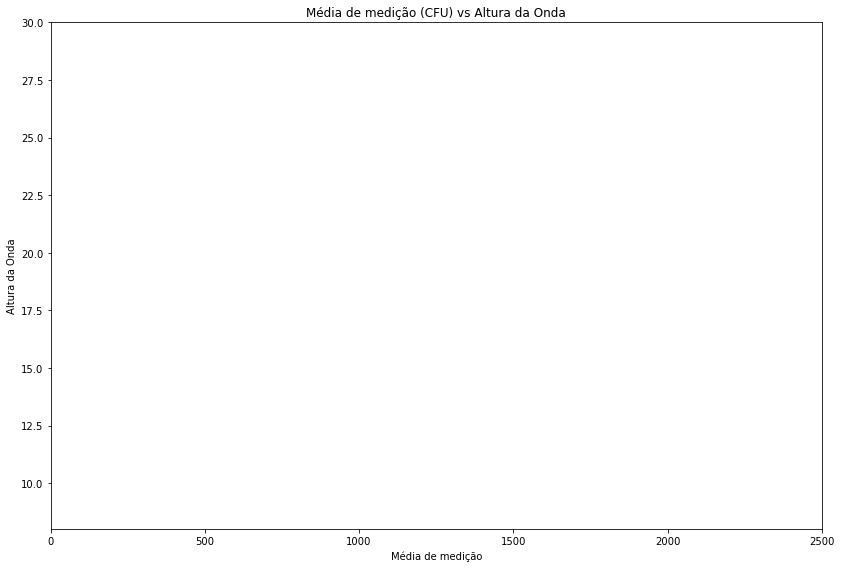

In [27]:
fig = plt.figure(figsize=(12, 8))
plt.scatter(Altura_Onda.ReadingMean, Altura_Onda.WaveHeight, c='red', alpha=0.1)
plt.title('Média de medição (CFU) vs Altura da Onda')
plt.xlabel('Média de medição')
plt.ylabel('Altura da Onda')

plt.plot((Altura_Onda.ReadingMean.min(),Altura_Onda.ReadingMean.max()), (a*Altura_Onda.ReadingMean.min()+b, a*Altura_Onda.ReadingMean.max()+b), color='blue')

plt.tight_layout()
plt.axis([0,2500,8,30])
plt.show()

In [29]:
# Regressão entre ReadingMean e Altura da Onda com ajuste linear

a = Periodo_Onda.ReadingMean.cov(Periodo_Onda.WavePeriod) / Periodo_Onda.ReadingMean.var()
b = Periodo_Onda.WavePeriod.mean() - a*Periodo_Onda.ReadingMean.mean()

print('Ajuste linear entre X3 e X4:')
print('Coeficiente linear:', b)
print('Coeficiente angular:', a)

Ajuste linear entre X3 e X4:
Coeficiente linear: -1572.07160222
Coeficiente angular: -0.065256611606


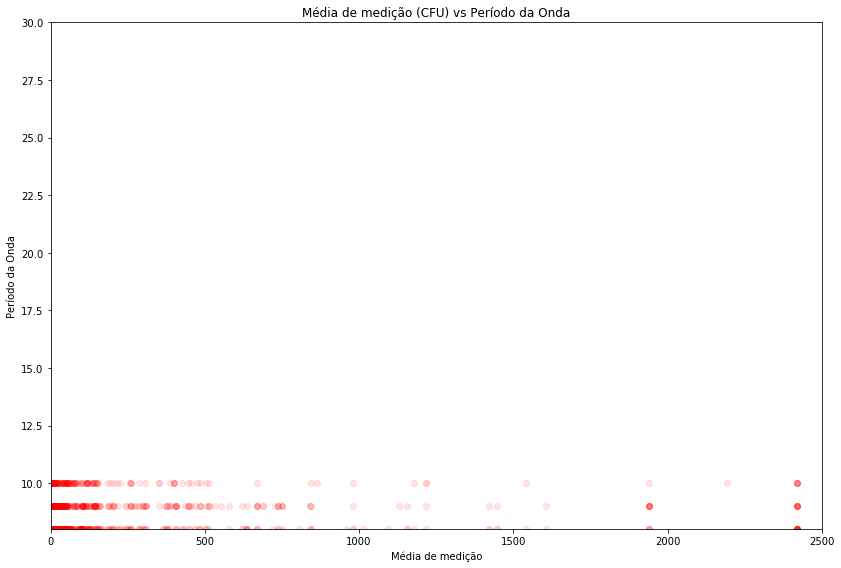

In [30]:
fig = plt.figure(figsize=(12, 8))
plt.scatter(Periodo_Onda.ReadingMean, Periodo_Onda.WavePeriod, c='red', alpha=0.1)
plt.title('Média de medição (CFU) vs Período da Onda')
plt.xlabel('Média de medição')
plt.ylabel('Período da Onda')

plt.plot((Periodo_Onda.ReadingMean.min(),Periodo_Onda.ReadingMean.max()), (a*Periodo_Onda.ReadingMean.min()+b, a*Periodo_Onda.ReadingMean.max()+b), color='blue')

plt.tight_layout()
plt.axis([0,2500,8,30])
plt.show()

# -------------------------

[0, 1000, 8, 30]

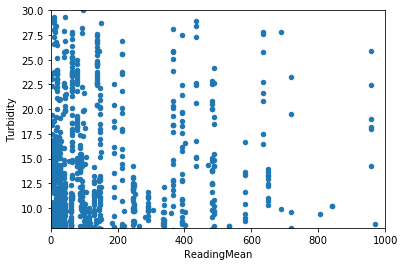

In [41]:
#Plota o gráfico de dispersão
new_df.plot.scatter('ReadingMean','Turbidity')
plt.axis([0,1000,8,30])

In [42]:
print("Covariância entre ReadingMean e Turbidity:",new_df.ReadingMean.cov(new_df.Turbidity))

print("Correlação entre ReadingMean e Turbidity:",new_df.ReadingMean.corr(new_df.Turbidity))


Covariância entre ReadingMean e Turbidity: -281.558386995
Correlação entre ReadingMean e Turbidity: -0.0178108986067


In [43]:
# Regressão entre ReadingMean e WaterTemperature com ajuste linear

a = new_df.ReadingMean.cov(new_df.Turbidity) / new_df.ReadingMean.var()
b = new_df.Turbidity.mean() - a*new_df.ReadingMean.mean()

print('Ajuste linear entre X3 e X4:')
print('Coeficiente linear:', b)
print('Coeficiente angular:', a)

Ajuste linear entre X3 e X4:
Coeficiente linear: 4.82831140016
Coeficiente angular: -0.00137499407935


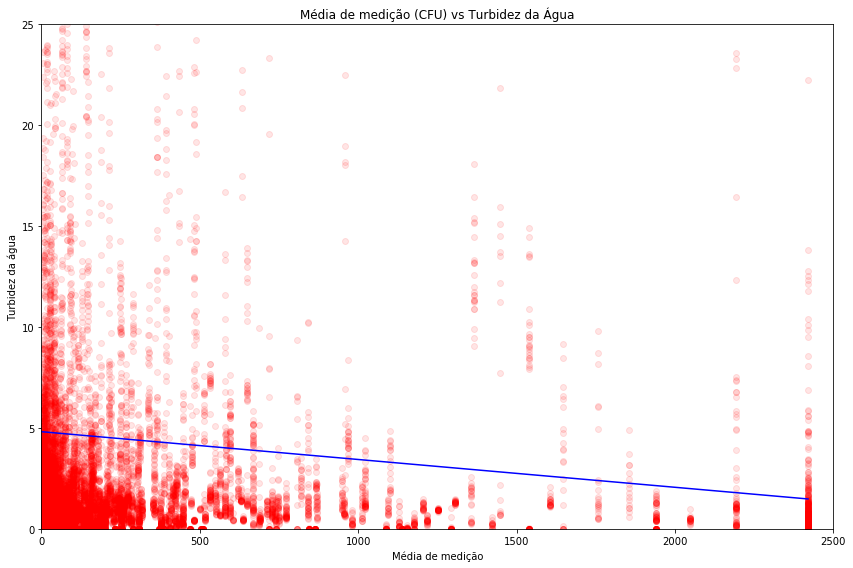

In [44]:
fig = plt.figure(figsize=(12, 8))
plt.scatter(new_df.ReadingMean, new_df.Turbidity, c='red', alpha=0.1)
plt.title('Média de medição (CFU) vs Turbidez da Água')
plt.xlabel('Média de medição')
plt.ylabel('Turbidez da água')

plt.plot((new_df.ReadingMean.min(),new_df.ReadingMean.max()), (a*new_df.ReadingMean.min()+b, a*new_df.ReadingMean.max()+b), color='blue')

plt.tight_layout()
plt.axis([0,2500,0,25])
plt.show()

[0, 2500, 1, 2.5]

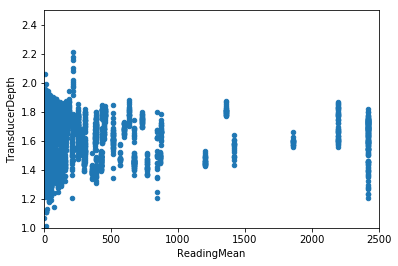

In [45]:
#Plota o gráfico de dispersão
new_df.plot.scatter('ReadingMean','TransducerDepth')
plt.axis([0,2500,1,2.5])

In [46]:
print("Covariância entre ReadingMean e TransducerDepth:",new_df.ReadingMean.cov(new_df.TransducerDepth))

print("Correlação entre ReadingMean e TransducerDepth:",new_df.ReadingMean.corr(new_df.TransducerDepth))


Covariância entre ReadingMean e TransducerDepth: 0.108460289858
Correlação entre ReadingMean e TransducerDepth: 0.00148501267252


In [47]:
# Regressão entre ReadingMean e WaterTemperature com ajuste linear

a = new_df.ReadingMean.cov(new_df.TransducerDepth) / new_df.ReadingMean.var()
b = new_df.TransducerDepth.mean() - a*new_df.ReadingMean.mean()

print('Ajuste linear entre X3 e X4:')
print('Coeficiente linear:', b)
print('Coeficiente angular:', a)

Ajuste linear entre X3 e X4:
Coeficiente linear: 1.61551140455
Coeficiente angular: 5.29667249449e-07


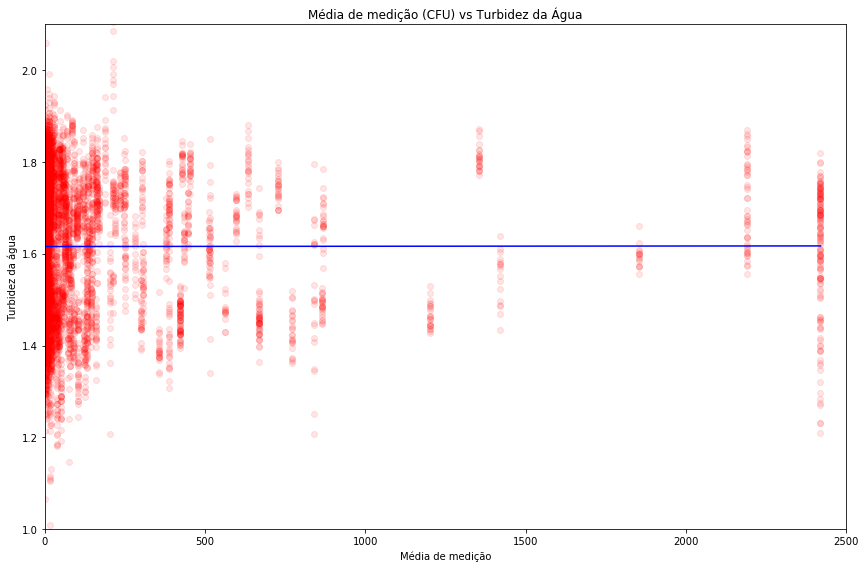

In [48]:
fig = plt.figure(figsize=(12, 8))
plt.scatter(new_df.ReadingMean, new_df.TransducerDepth, c='red', alpha=0.1)
plt.title('Média de medição (CFU) vs Turbidez da Água')
plt.xlabel('Média de medição')
plt.ylabel('Turbidez da água')

plt.plot((new_df.ReadingMean.min(),new_df.ReadingMean.max()), (a*new_df.ReadingMean.min()+b, a*new_df.ReadingMean.max()+b), color='blue')

plt.tight_layout()
plt.axis([0,2500,1,2.1])
plt.show()

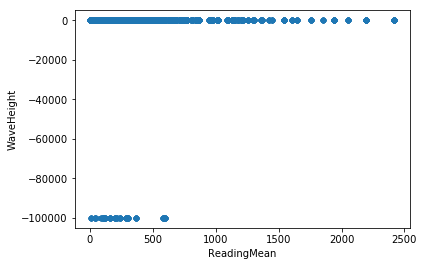

In [49]:
#Plota o gráfico de dispersão
new_df.plot.scatter('ReadingMean','WaveHeight')


In [50]:
print("Covariância entre ReadingMean e WaveHeight:",new_df.ReadingMean.cov(new_df.WaveHeight))

print("Correlação entre ReadingMean e WaveHeight:",new_df.ReadingMean.corr(new_df.WaveHeight))


Covariância entre ReadingMean e WaveHeight: -13502.1312268
Correlação entre ReadingMean e WaveHeight: -0.00237648274161


In [51]:
# Regressão entre ReadingMean e WaterTemperature com ajuste linear

a = new_df.ReadingMean.cov(new_df.WaveHeight) / new_df.ReadingMean.var()
b = new_df.WaveHeight.mean() - a*new_df.ReadingMean.mean()

print('Ajuste linear entre X3 e X4:')
print('Coeficiente linear:', b)
print('Coeficiente angular:', a)

Ajuste linear entre X3 e X4:
Coeficiente linear: -1575.68101962
Coeficiente angular: -0.0659378351096


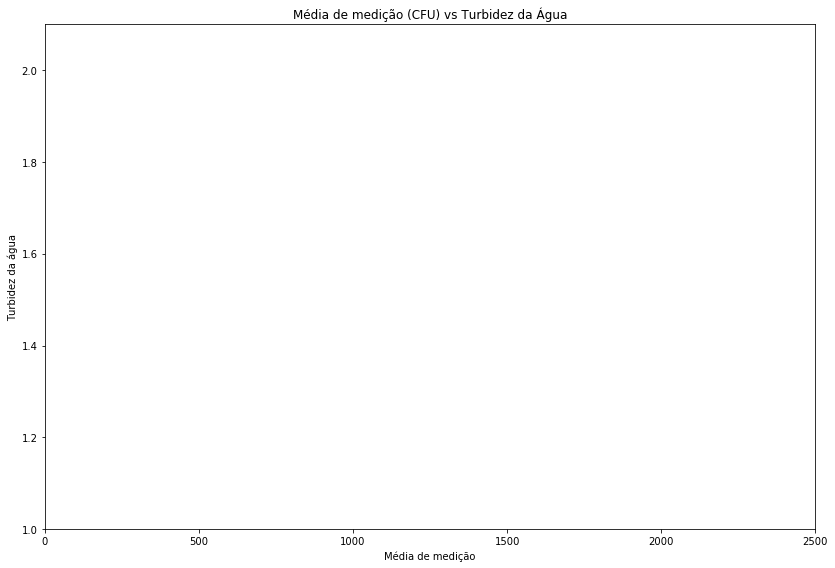

In [54]:
fig = plt.figure(figsize=(12, 8))
plt.scatter(new_df.ReadingMean, new_df.WaveHeight, c='red', alpha=0.1)
plt.title('Média de medição (CFU) vs Turbidez da Água')
plt.xlabel('Média de medição')
plt.ylabel('Turbidez da água')

plt.plot((new_df.ReadingMean.min(),new_df.ReadingMean.max()), (a*new_df.ReadingMean.min()+b, a*new_df.ReadingMean.max()+b), color='blue')

plt.tight_layout()
plt.axis([0,2500,1,2.1])
plt.show()